In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

note that change the data source


In [2]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\data.csv")

In [3]:
data=data[::-1]
data = data.reset_index(drop=True)

time=data['Date']
data=data.drop(['Date','BTC_change'], axis=1)

target="BTC_close"

In [4]:
data

,BTC_close,BTC_open,BTC_high,BTC_low,difficulty,addresses_active_count,sum_lock_weight,mean_lock_size_ytes,total_fees_usd,mean_hash_rate,...,ETH,LTC,XRP,DOGE,COPPER,GOLD,SILVER,SPX,JP225,DJI
0,415.8,412.8,417.5,410.3,158427203767,445273,426654988,6.881532e+05,1.731272e+04,1.220696e+06,...,0.00,0.00,0.00000,0.000000,0.0000,0.00,0.000,0.00,0.0,0.0
1,419.1,415.8,422.4,415.1,158427203767,434658,398582424,6.227850e+05,1.710193e+04,1.260073e+06,...,0.00,0.00,0.00000,0.000000,0.0000,0.00,0.000,0.00,0.0,0.0
2,410.4,419.1,420.7,407.0,158427203767,374730,331208848,5.750154e+05,1.398444e+04,1.134066e+06,...,0.00,0.00,0.00000,0.000000,0.0000,0.00,0.000,0.00,0.0,0.0
3,412.4,410.4,415.9,409.6,158427203767,421585,334817852,6.293569e+05,1.460678e+04,1.047436e+06,...,0.00,0.00,0.00000,0.000000,0.0000,0.00,0.000,0.00,0.0,0.0
4,414.3,412.4,416.1,411.2,158427203767,451902,437739524,7.199663e+05,1.689298e+04,1.197070e+06,...,0.00,0.00,0.00000,0.000000,0.0000,0.00,0.000,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,26339.7,26515.0,26679.3,26290.6,52350439455487,883864,603064705,1.985675e+06,7.946708e+05,3.929555e+08,...,1720.98,77.20,0.48699,0.062107,3.8738,1969.45,24.198,0.00,0.0,0.0
2657,26845.9,26339.7,27029.7,26295.1,52350439455487,920552,567091224,1.758290e+06,8.514319e+05,3.695343e+08,...,1737.06,77.51,0.49341,0.062429,3.8643,1964.05,24.062,0.00,0.0,0.0
2658,28307.7,26845.9,28393.0,26665.5,52350439455487,951926,543133484,1.677592e+06,1.052364e+06,3.539202e+08,...,1791.61,80.31,0.49270,0.063108,3.8835,1947.70,23.234,4388.71,33155.0,34356.0
2659,29996.9,28307.7,30769.5,28270.5,52350439455487,920555,483181576,1.611773e+06,1.347976e+06,3.148849e+08,...,1889.87,85.12,0.49995,0.065644,3.9135,1944.90,22.810,4365.69,33390.0,34235.0


In [5]:
data.columns

Index(['BTC_close', 'BTC_open', 'BTC_high', 'BTC_low', 'difficulty',
       'addresses_active_count', 'sum_lock_weight', 'mean_lock_size_ytes',
       'total_fees_usd', 'mean_hash_rate', 'xfer_cnt', 'mean_tx_size_usd',
       'ETH', 'LTC', 'XRP', 'DOGE', 'COPPER', 'GOLD', 'SILVER', 'SPX', 'JP225',
       'DJI'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


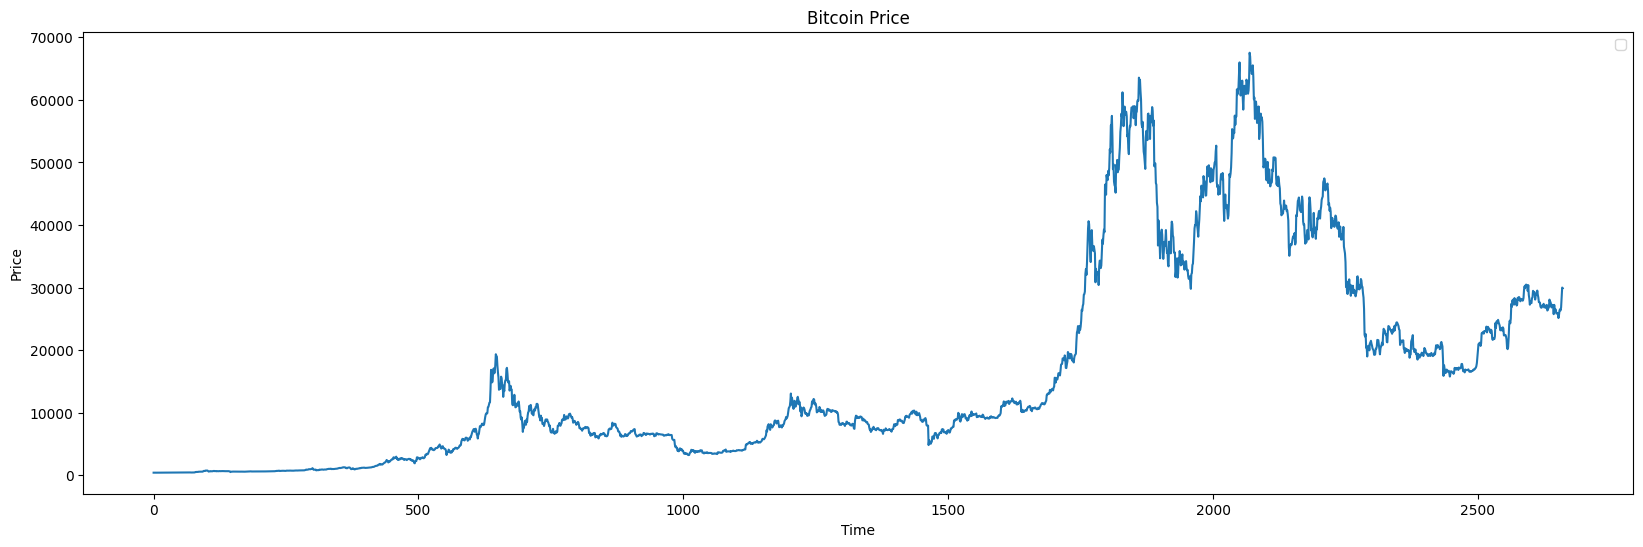

In [6]:
plt.figure(figsize=(20, 6))

plt.plot(data[target])
plt.title('Bitcoin Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
target=np.array(target)
target.shape

()

splitting data to train, valid, test set

In [8]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [9]:
train_time=time[:int(0.7*len(data))]
val_time=time[int(0.7*len(data)):int(0.85*len(data))]
test_time=time[int(0.85*len(data)):]

In [10]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

In [11]:
time_step=30
train_time_line=[]
val_time_line=[]
test_time_line=[]

**Create data sequence, sequence length is time step and predict y is the right next day**

In [12]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    target=df[:,close_col_idx]
    for i in range(len(df)-timesteps):  
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=target[i:i+timesteps][::1]
        max1,min1=max(target[i:i+timesteps]),min(target[i:i+timesteps])
        value1 = np.concatenate([value, [max1 * 1.2, min1 * 1.2]],axis=0)
        # print(value1.shape,value.shape)
        scaler.fit(value1.reshape(-1,1))
        # print(target[i+timesteps].reshape(-1,1).shape)
        value1=scaler.transform(target[i+timesteps].reshape(-1,1))
        y.append(value1)
    return np.array(x),np.array(y),timeLine


In [13]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'))
test_y=test_y.reshape(-1)
train_y,val_y=train_y.reshape(-1),val_y.reshape(-1)

**Build Model**

In [32]:

model = Sequential()
model.add(LSTM(units=128,return_sequences=True,recurrent_dropout=0.25))
model.add(LSTM(units=128,return_sequences =True,recurrent_dropout=0.25))
model.add(LSTM(units=64,return_sequences=False,recurrent_dropout=0.25))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
moniter=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=1, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])
model.summary()

58/58 [==============================] - 14s 111ms/step - loss: 0.0423 - val_loss: 0.0466
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 128)           77312     
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           131584    
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 259361 (1013.13 KB)
Trainable params: 259361 (1013.13 KB)
Non-trainable params: 0 

In [33]:
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=100, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])

Epoch 1/100
58/58 [==============================] - 15s 116ms/step - loss: 0.0235 - val_loss: 0.0218
Epoch 2/100
58/58 [==============================] - 6s 95ms/step - loss: 0.0185 - val_loss: 0.0130
Epoch 3/100
58/58 [==============================] - 5s 94ms/step - loss: 0.0150 - val_loss: 0.0117
Epoch 4/100
58/58 [==============================] - 5s 90ms/step - loss: 0.0138 - val_loss: 0.0098
Epoch 5/100
58/58 [==============================] - 5s 88ms/step - loss: 0.0124 - val_loss: 0.0085
Epoch 6/100
58/58 [==============================] - 5s 92ms/step - loss: 0.0126 - val_loss: 0.0090
Epoch 7/100
58/58 [==============================] - 6s 97ms/step - loss: 0.0117 - val_loss: 0.0086
Epoch 8/100
58/58 [==============================] - 5s 92ms/step - loss: 0.0108 - val_loss: 0.0090
Epoch 9/100
58/58 [==============================] - 5s 91ms/step - loss: 0.0106 - val_loss: 0.0084
Epoch 10/100
58/58 [==============================] - 5s 89ms/step - loss: 0.0097 - val_loss: 0.00

In [34]:
model.evaluate(train_x,train_y)
model.evaluate(val_x,val_y)
model.evaluate(test_x,test_y)

12/12 [==============================] - 1s 20ms/step - loss: 0.0108


0.010820754803717136

In [35]:

prec_train=model.predict(train_x)
pre_val=model.predict(val_x)
predictions = model.predict(test_x)
test_y=test_y.reshape(-1,1)

12/12 [==============================] - 0s 16ms/step


In [36]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return np.array(result)


In [37]:
predic_after_inverse=inverseTransform(predictions,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(prec_train,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

**Problem Visualization**

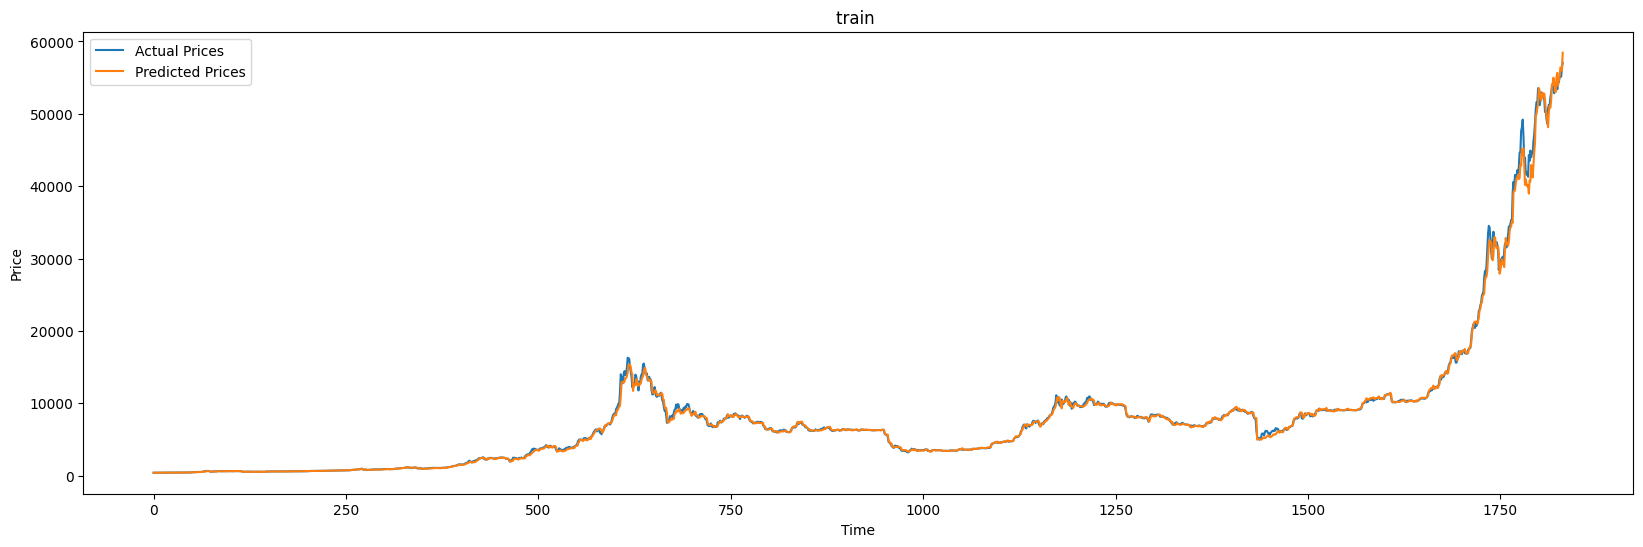

In [38]:

# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train ')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

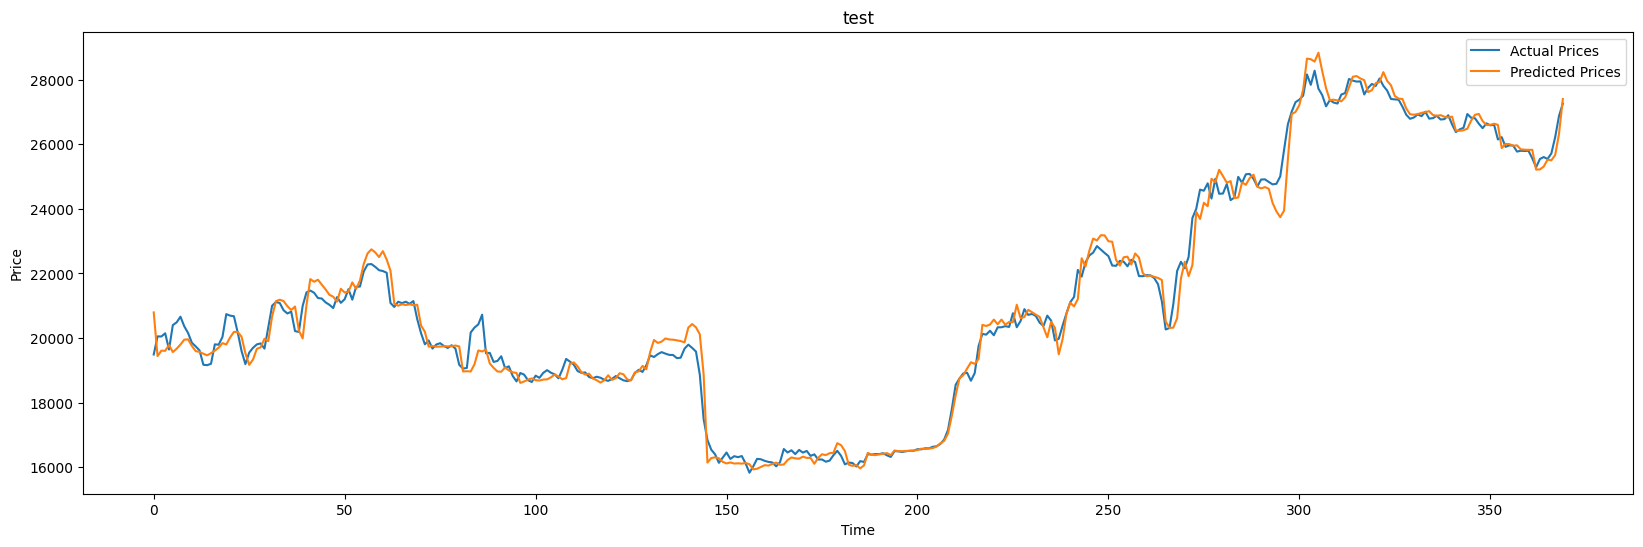

In [39]:

# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(predic_after_inverse, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

**Evaluating accuracy of model by RMSE,MAPE, ACC**

In [40]:

true_train=inverse_train_true 
prediction_train=inverse_train_pred
prediction_test=predic_after_inverse
true_test=true_after_inverse
def print_evaluation_results(true_values, predicted_values, dataset_name):
    print("Test ACCuracy for", dataset_name)
    print("------------------------------------------------------")
    # RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print("Root Mean Square Error (RMSE): {:.4f}".format(rmse))
    
    # MAPE
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))

    #r2 score
    print("R2 score: ", r2_score(true_values,predicted_values))

# Print evaluation results for the train set
print_evaluation_results(true_train, prediction_train, "train set")

# Print evaluation results for the test set
print_evaluation_results(true_test, prediction_test, "test set")


Test ACCuracy for train set
------------------------------------------------------
Root Mean Square Error (RMSE): 504.5271
Mean Absolute Percentage Error (MAPE): 0.0222
R2 score:  0.997251538615372
Test ACCuracy for test set
------------------------------------------------------
Root Mean Square Error (RMSE): 401.1313
Mean Absolute Percentage Error (MAPE): 0.0131
R2 score:  0.987342840134227
